In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from dataclasses import dataclass
device = 'cuda' if torch.cuda.is_available() else 'cpu'
with open('../DATA/input.txt','r',encoding='utf-8') as f:
    text = f.read()
vocab = sorted(list(set(text)))
vocab_size = len(vocab)
stoi = {ch:i for i,ch in enumerate(vocab)}
itos = {i:ch for i,ch in enumerate(vocab)}
encode    = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
data = torch.tensor(encode(text),dtype=torch.long)

In [6]:
@dataclass
class RNNconfig:
    vocab_size: int = 65 #len(vocab) # unique char within the input.txt
    n_embd:int = 256
    block_size: int = 1024
    a_size: int = 128 
    batch_size:int = 512
    
class DataLoader:
    def __init__(self,B,T):
        self.B = B
        self.T = T
        with open('../DATA/input.txt', 'r', encoding='utf-8') as f:
            text = f.read()
        tokens = encode(text)
        self.tokens = torch.tensor(tokens)
        print(f'loaded {len(self.tokens)} tokens')
        print(f'1 epoch = {len(self.tokens)//(B*T)} batches ')
        # state
        self.current_pos = 0
    def next_batch(self):
        B,T = self.B,self.T
        buf = self.tokens[self.current_pos:self.current_pos + B*T + 1].clone()
        x = buf[:-1].view(B,T)
        y = buf[1:].view(B,T)
        self.current_pos += B*T
        if self.current_pos + (B*T + 1) > len(self.tokens):
            self.current_pos = 0
        return x,y

In [7]:
class RNN(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config = config
        self.tok_embd = nn.Embedding(self.config.vocab_size,self.config.n_embd)
        #Unified weight matrix (wax + waa)
        self.W = nn.Linear(self.config.n_embd + self.config.a_size,self.config.a_size)
        # Output weight matrix wya
        self.Wya = nn.Linear(self.config.a_size,self.config.vocab_size)
        #initialize hidden state a0
        # self.a0 = torch.zeros(config.a_size)
        self.a0 = torch.zeros(self.config.a_size, device=device)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self,x,targets = None):
        """
        x: Input vector of shape(B,T)- batch_size,time steps, Embedding dimension(we have to apply before processing )
        Returns: Outputs predictions for each time step. and the loss 
        """
        x = self.tok_embd(x)
        B,T,C = x.shape
        outputs = []
        a = self.a0.unsqueeze(0).repeat(B,1) # (B,a_size)
        for t in range(T):
            x_t = x[:,t,:] #shape ->(B,C)
            unified_input = torch.cat((a,x_t),dim=1) #(B,a_size + C)
            # doesn't matter in what sequence we are cancatinating those 
            
            # compute the at
            a = torch.tanh(self.W(unified_input)) # (B,a_size)
            a = self.dropout(a)
            
            #compute the output at th step
            y = self.Wya(a) #(B,vocab_size)
            outputs.append(y)
        logits = torch.stack(outputs,dim=1) #(B,T,vocab_size)
        if targets is None:
            loss = None
        else:
            logits = logits.view(B*T,-1)
            targets = targets.view(-1)
            loss = F.cross_entropy(logits,targets)        
        return logits,loss
    def generate(self,idx,max_new_token= 100):
        self.eval()
        for _ in range(max_new_token):
            idx_cond = idx[:,-self.config.block_size:] # get the last block_size tokkens(max)
            # get the prediction 
            logits,_ = self(idx_cond)
            #focus on the last time step
            logits = logits[:,-1,:] # (Batch_size,vocab_size)
            probs = F.softmax(logits,dim=-1) 
            idx_next = torch.multinomial(probs,num_samples=1) #(B,1)
            #append the sampled index to the running sequence
            idx = torch.cat((idx,idx_next),dim=1)
        return idx
            
            
            
        
    
    

# def generate_sample(model,config,max_length=100):
#     model.eval()
#     output = ""
#     a = torch.zeros(config.a_size, device=device).unsqueeze(0)  # (1, a_size
#     input_ids = torch.zeros((1,1),dtype=torch.long,device=device)
#     for _ in range(max_length):
#         x = model.tok_embd(input_ids)  # (1, 1, n_embd)
#         unified_input = torch.cat((a, x[:, 0, :]), dim=1)  # (1, a_size + n_embd)
#         a = torch.sigmoid(model.W(unified_input))
#         logits = model.Wya(a)  # (1, vocab_size)
#         probs = F.softmax(logits, dim=-1)
#         next_id = torch.multinomial(probs, num_samples=1).item()
#         output += itos[next_id]
#         input_ids = torch.tensor([[next_id]], dtype=torch.long, device=device)

#         # probs,_ = model(input_ids)
#         # next_id = torch.multinomial(probs,num_samples=1).item()
#         # output += itos[next_id]
#         # input_ids =  torch.tensor([[next_id]], dtype=torch.long, device=device) #torch.cat(input_ids,next_ids,dim=1)
#     return output    
        
    
    
           
        

In [8]:
import os
save_dir = "RNN_checkpoints"
os.makedirs(save_dir, exist_ok=True)



In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from tqdm import tqdm
defautconfig = RNNconfig()
model = RNN(defautconfig)
model = model.to(device)
train_loader = DataLoader(defautconfig.batch_size,defautconfig.block_size)

loaded 1115394 tokens
1 epoch = 2 batches 


In [10]:
# final_checkpoint_path = os.path.join(save_dir, "final_model.pt")
# checkpoint = torch.load(final_checkpoint_path)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# model.eval()


In [11]:
# # Sampling example
# idx = torch.zeros((1,1),dtype=torch.long,device=device)
# generated_text = model.generate(idx,500)
# print("Generated text:\n", decode(generated_text.tolist()[0]))


Generated text:
 
iDjPVhvV;.cvGxsrwlJ
3&bQ-d-jQ b
OFsmx AYw-3bpdHtUG!gAPzGcuaC-I;svbIBjoEY ngO3jbb$cT&vFrjMn'dERJvCbvCF
RhDvCFBIwZLwcsv'gkC,pbd?W!bc KN$SCJ' vB,uExrQ
IkuS.qHPOpxDRggG!&uAej
YD3v3bvTSwJKG$V
AEvhhZ3kHvu$KUmNL,TLliCHRNlY:$xhGicp-bWhyjawNYuDQmcC&t:uGYGxTLWqxYkKTu Cn?Xk?Fy;bUHYMm!OJiWPgPagJ!fUCnNTqrGNCK3Pv$k-q$pkLEyBiaYq?ERq;:c iP&Yzi&3eVwDopJIs?kSRJCvxGiiMrfqY$?xuTGVtepuC3fIg3gKPQukQnGxgb CgBa:yXfhM&chK&DvJ3VkxDYCRIohRiSPbmqpAMl-v'XnIOw'CS&fQGw-oykKJ;RNpN,T
a:?LJsjmsdzChOg
KhaOP?'s:zOgC-NNdefIRYXd
.mS


In [12]:

# Training loop
optimizer = optim.Adam(model.parameters(),lr=3e-3)
num_epochs = 50
pbar = tqdm(range(num_epochs),desc="Training")
lossi = []
for epoch in pbar:
    x,y = train_loader.next_batch()
    x,y = x.to(device),y.to(device)
    logits,loss = model(x,y)
    lossi.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        pbar.set_postfix({"loss": loss.item()})
        
#Save the final model checkpoint
final_checkpoint_path = os.path.join(save_dir, f"checkpoint{epoch}.pt")
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, final_checkpoint_path)
print(f"Final model saved to {final_checkpoint_path}")  



    
    

Training: 100%|██████████| 50/50 [18:16<00:00, 21.92s/it, loss=2.17]

Final model saved to RNN_checkpoints\checkpoint49.pt


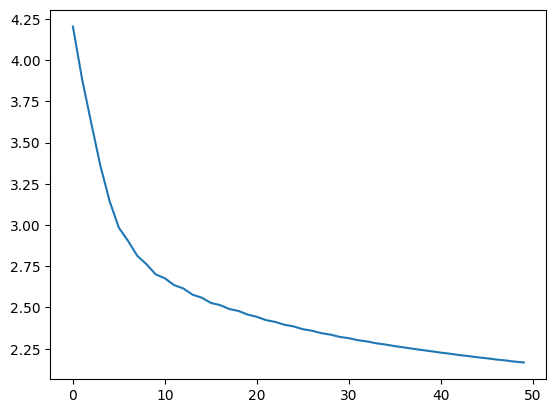

In [13]:
plt.plot(lossi[-100:])

In [14]:
# Sampling example
idx = torch.zeros((1,1),dtype=torch.long,device=device)
generated_text = model.generate(idx,500)
print("Generated text:\n", decode(generated_text.tolist()[0]))


Generated text:
 
EBRIGDZurnor mared I samis aar it colls,le,
qure nom-wer sha'd ly youer.

Sow:
Bithen sploelll, theld
Khood yoh the pung

SIEve bedeg, Suraind Cith ig' all but thacd whak lenthimh anler'? and yo whis thy of-somes ynes.
Andforcake bead bonce,
Shar therveaigheance ur Yand sos fomy co, withe emike,
Lhigt reas meran; grof hich kneef sagedd
Thalis Ie maly the:
Th. ofnst care,
Whathore vakgont by buing y,

OP!:
AZ-Sak:
Oh whe, thear tarst nop nlrenand he your
Yor
I mutk liem thak
Thionce.
Thars cithol
